## 자연어 처리 과제입니다

파일명 제출 : nlp_{이름}.ipynb  
제출기한일 : 2023.10.10  
제출 이메일 : bluelemonsky7@gmail.com  
분석 대상 데이터 : 네이버 평점 test 데이터

평가 관점
1. 코드를 작성하여 error 없이 진행해야 함
2. 각종 모델을 비교하거나 선택한 이유 등을 작성
3. train : test 비율은 7:3으로 함
4. 최종 평가에서 train 데이터에 대한 정확도 90 이상, test 데이터에 대한 정확도는 85 이상을 목표로 함
5. 모델 평가에서 고정된 결과가 나오도록 하세요

### 0. 요약
---
1. 네이버 평점 데이터 중 test 데이터를 이용해 학습을 진행하고 감성 분석을 진행해보았다.
2. 벡터화 과정에 어려움이 많아서 딥러닝을 통한 학습으로 선회했다.
    
3. 분석은 아래의 순서로 진행하였다.   
    데이터 로드 -> 결측치 제거 -> 한글 이외의 데이터 제거 -> 시각화 -> 불용어 지정 -> 토큰화 -> 빈도가 1인 토큰 제거 -> 토큰 제거로 사라진 문장 제거 -> 최대 길이 지정 -> 패딩 -> 모델 학습 -> 평가
    
4. 학습 진행을 위한 경우의 수 조합은 불용어와 모델을 바꿔가며 진행했다
5. 불용어는 아래의 3가지 경우로 나눴다.
    1. ['은','는','이','가','를','와','과','의','에','들']
    2. ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자']
    3. ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자','영화']<p>
6. 모델은 LSTM, GRU, CNN 을 이용했다.
    1. 랜덤 시드 초기화 함수를 통해 고정된 결과가 나올 수 있도록 하였다.

---
결과

    - 불용어 1번 + LSTM / Accuracy: 0.8244
    - 불용어 2번 + LSTM / Accuracy: 0.8267
    - 불용어 3번 + LSTM / Accuracy: 0.8213
    - 불용어 1번 + GRU  / Accuracy: 0.8264
    - 불용어 2번 + GRU  / Accuracy: 0.8294 <- 최고 점수
    - 불용어 3번 + GRU  / Accuracy: 0.8273
    - 불용어 1번 + CNN  / Accuracy: 0.8216
    - 불용어 2번 + CNN  / Accuracy: 0.8178
    - 불용어 3번 + CNN  / Accuracy: 0.8227

---

#### Part 1 . 분석 환경에 대한 정보를 보여주세요

1. python 버전 
2. 주용 사용 패키지 버전 정보 


##### 파이썬 버젼: 3.10.9
- konlpy - 0.6.0
- sklearn - 1.2.1
- pandas - 1.5.3
- tqdm - 4.64.1
- plotly - 5.9.0
- tensorflow - 2.13.0
- matplotlib - 3.7.0

In [1]:
# 정규 표현식 패키지
import re 

# 토크나이저 패키지
from konlpy.tag import Okt

# 모델 분류 및 평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 데이터 핸들링
import numpy as np
import pandas as pd

# 기타
from tqdm import tqdm # 분석 속도, 시간 확인, 정도 확인  
import pickle

# 시각화
import matplotlib.pyplot as plt
import plotly.express as px

# 딥러닝 패키지
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import tensorflow as tf
import random

#### Part 2. 분석 데이터를 로드하세요

1. 판다스로 데이터를 read 하세요

In [3]:
data = pd.read_csv('./data/ratings_test.csv')

In [4]:
data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


#### Part 3. 텍스트 데이터를 EDA하세요

1. 통계적으로 텍스트를 확인해 보세요
2. 시각화 해보세요
3. 불용어(stop words)를 찾아보세요
4. 기타 여러 방법으로 EDA를 해보세요

##### 중복 제거

In [5]:
data['document'].nunique()

49157

In [6]:
test_df = data.drop_duplicates(subset=['document']).reset_index(drop=True)

##### 각 레이블의 숫자 알아보기

In [8]:
fig = px.histogram(test_df, x = 'label', text_auto=True)
fig.update_layout(bargap=0.5)
fig.show()

##### 결측치 제거

In [9]:
test_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [10]:
test_df.dropna(inplace=True)

In [11]:
test_df.isnull().sum()

id          0
document    0
label       0
dtype: int64

##### 한글 이외의 텍스트 제거

In [12]:
test_df['document'] = test_df['document'].apply(lambda x: re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))

In [13]:
test_df

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
...,...,...,...
49153,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49154,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49155,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49156,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


##### 공백만 남은 행 제거

In [14]:
test_df['document'] = test_df['document'].str.replace('^ +', "")

C:\Users\jjun\AppData\Local\Temp\ipykernel_19784\915650084.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [15]:
test_df['document'].replace('', np.nan, inplace=True)
print(test_df.isnull().sum())

id            0
document    305
label         0
dtype: int64


In [16]:
test_df = test_df.dropna().reset_index(drop=True)

##### 긍정 단어, 부정 단어 알아보기

In [147]:
label_1 = test_df[test_df['label'] == 1]
label_0 = test_df[test_df['label'] == 0]

In [148]:
label_1

,id,document,label
0,6270596,굳 ㅋ,1
4,7898805,음악이 주가 된 최고의 음악영화,1
8,6242223,이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 모든 사람이 그렇지는 않네,1
9,7462111,괜찮네요오랜만포켓몬스터잼밌어요,1
11,6900881,청춘은 아름답다 그 아름다움은 이성을 흔들어 놓는다 찰나의 아름다움을 잘 포착한 섬...,1
...,...,...,...
48843,9653062,재밌는데평점이왜,1
48844,1077821,내일 토요일밤 에서 영화 해준다 봐야지 기대,1
48845,5494272,액션영화로 기대하지말고 스릴러영화라 생각하고 보면 괜찮은 영화인듯,1
48846,5567676,정말 너무 재밌음 ㅋ,1


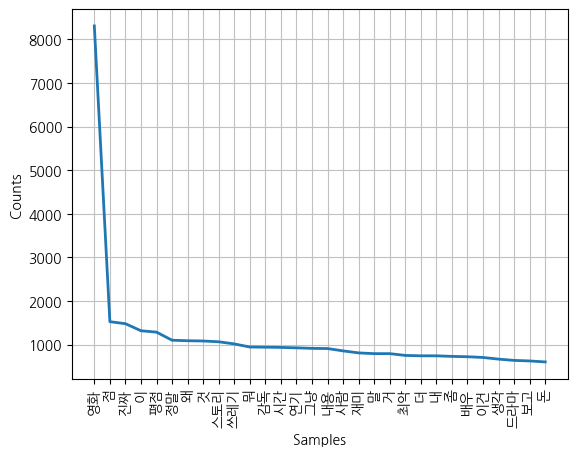

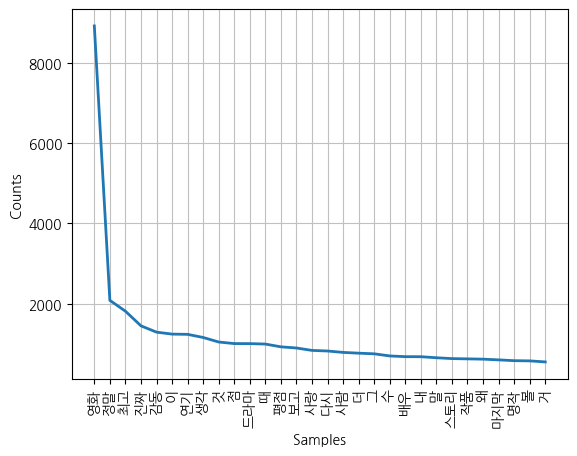

In [188]:
from nltk import Text
import matplotlib.pyplot as plt
import koreanize_matplotlib

okt = Okt()

label_0_reviews = ' '.join(label_0['document'].astype('str'))
label_1_reviews = ' '.join(label_1['document'].astype('str'))

label_0_review_nouns = Text(okt.nouns(label_0_reviews), name = 'naver movie review')
label_1_review_nouns = Text(okt.nouns(label_1_reviews), name = 'naver movie review')

label_0_review_nouns.plot(30)
label_1_review_nouns.plot(30)
plt.show()

##### 워드클라우드

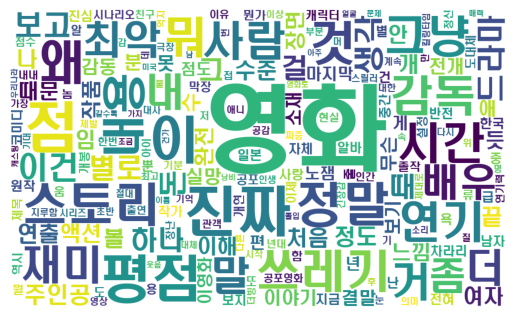

In [490]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

font_path = 'C:/Windows/Fonts/H2HDRM.TTF'

# 부정 리뷰 워드클라우드

wc = WordCloud(width = 1000, height = 600, background_color = 'white', font_path = font_path)
plt.imshow(wc.generate_from_frequencies(label_0_review_nouns.vocab()))
plt.axis('off')
plt.show()

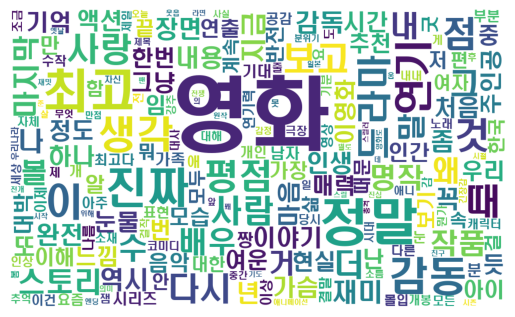

In [491]:
# 긍정 리뷰 워드클라우드

wc = WordCloud(width = 1000, height = 600, background_color = 'white', font_path = font_path)
plt.imshow(wc.generate_from_frequencies(label_1_review_nouns.vocab()))
plt.axis('off')
plt.show()

##### 불용어 지정

In [425]:
stopwords = ['은','는','이','가','를','와','과','의','에','들']

In [346]:
stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자']

In [456]:
# 영화라는 단어는 긍정과 부정 모두에 비슷한 비율로 많이 나옴
## -> 없는게 낫지 않을까?

stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자','영화']

#### Part 4. 텍스트 데이터를 임베딩 하세요

1. 텍스트 토크나이즈를 해보세요
2. 텍스트를 벡터화 하세요

##### train test split

In [457]:
X = test_df['document']
y = test_df['label']

In [458]:
x_train, x_test, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.3, random_state=42)

##### 토큰화

In [459]:
X_train_fs = []
for sentence in tqdm(x_train):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train_fs.append(stopwords_removed_sentence)

100%|██████████| 34196/34196 [01:23<00:00, 411.44it/s]


In [460]:
X_test_fs = []
for sentence in tqdm(x_test):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test_fs.append(stopwords_removed_sentence)

100%|██████████| 14656/14656 [00:36<00:00, 405.20it/s]


In [461]:
X_train, X_test = X_train_fs, X_test_fs

y_train, y_test = y_train_1, y_test_1

In [462]:
print(X_train[:3])

[['보통', '다른', '특별하다', '분위기', '독특하다', '반하다', '내', '인생', '최고', '다'], ['그냥', '보다', '배속', '그냥', '보다'], ['두다', '돈', '내다', '보다', '온몸', '전율', '인', '다']]


In [463]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

##### 빈도가 1인 토큰 제거

In [464]:
total = 0
unique = 0

for k, v in tokenizer.word_counts.items():
    total += 1
    if v <= 1:
        unique += 1

In [465]:
total, unique

(22702, 10496)

In [466]:
significant_vocab_size = total - unique + 1

In [467]:
significant_vocab_size

12207

In [468]:
tokenizer = Tokenizer(significant_vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [469]:
y_train = np.array(y_train)
y_test = np.array(y_test)

##### 토큰 제거 과정에서 사라진 문장 제거

In [470]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [471]:
len(drop_train)

87

In [472]:
sentences = []
for index, sentence in enumerate(X_train):
    if index not in drop_train:
        sentences.append(sentence)

In [473]:
X_train = sentences

In [474]:
y_train = np.delete(y_train, drop_train, axis=0)

In [475]:
# 확인

print(len(X_train))
print(len(y_train))

34109
34109


##### 문장 길이 확인

In [476]:
fig = px.histogram([len(review) for review in X_train], nbins=62, 
                   labels={'value':'length of samples',
                           'count':'number of samples'})
fig.show()

##### 최대 길이는 50으로 설정해서 패딩

In [477]:
max_len = 50

In [478]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [479]:
with open('tokenizer_sw15_movie.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

#### Part 5. 분류 모델을 훈련하고 적용해 보세요

In [502]:
with open('tokenizer_sw15_movie.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

##### 랜덤 시드 초기화용 함수
- 고정된 결과를 위해 모델 학습을 시행할 때마다 초기화 함수를 돌려줘야 함

In [480]:
from tensorflow import keras
import os

def reset_random_seed():
    seed_num = 42
    np.random.seed(seed_num)
    random.seed(seed_num)
    tf.random.set_seed(seed_num)
    keras.utils.set_random_seed(seed_num)
    tf.config.experimental.enable_op_determinism()

    os.environ['PYTHONHASHSEED'] = str(seed_num)

    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

##### LSTM

In [481]:
reset_random_seed()

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(significant_vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'./model/best_model_03.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
426/427 [============================>.] - ETA: 0s - loss: 0.4501 - acc: 0.7878
Epoch 1: val_acc improved from -inf to 0.81824, saving model to ./model\best_model_03.h5
427/427 [==============================] - 31s 71ms/step - loss: 0.4501 - acc: 0.7878 - val_loss: 0.3961 - val_acc: 0.8182
Epoch 2/15
  2/427 [..............................] - ETA: 26s - loss: 0.3431 - acc: 0.8203

C:\Users\jjun\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



426/427 [============================>.] - ETA: 0s - loss: 0.3113 - acc: 0.8691
Epoch 2: val_acc did not improve from 0.81824
427/427 [==============================] - 30s 70ms/step - loss: 0.3113 - acc: 0.8691 - val_loss: 0.4175 - val_acc: 0.8163
Epoch 3/15
426/427 [============================>.] - ETA: 0s - loss: 0.2443 - acc: 0.9006
Epoch 3: val_acc did not improve from 0.81824
427/427 [==============================] - 30s 71ms/step - loss: 0.2443 - acc: 0.9006 - val_loss: 0.4486 - val_acc: 0.8097
Epoch 4/15
426/427 [============================>.] - ETA: 0s - loss: 0.1954 - acc: 0.9248
Epoch 4: val_acc did not improve from 0.81824
427/427 [==============================] - 30s 70ms/step - loss: 0.1953 - acc: 0.9248 - val_loss: 0.5551 - val_acc: 0.8011
Epoch 5/15
426/427 [============================>.] - ETA: 0s - loss: 0.1574 - acc: 0.9393
Epoch 5: val_acc did not improve from 0.81824
427/427 [==============================] - 30s 69ms/step - loss: 0.1574 - acc: 0.9393 - val_lo

##### Bidirectional
- 실행 시간이 길고 결과도 좋지 않아서 제외

In [229]:
from keras.layers import Bidirectional

reset_random_seed()

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(significant_vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'./model/Bidirect_best_model_01.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
409/409 [==============================] - ETA: 0s - loss: 0.5180 - acc: 0.7222
Epoch 1: val_acc improved from -inf to 0.79997, saving model to ./model\Bidirect_best_model_01.h5
409/409 [==============================] - 95s 224ms/step - loss: 0.5180 - acc: 0.7222 - val_loss: 0.4318 - val_acc: 0.8000
Epoch 2/15
409/409 [==============================] - ETA: 0s - loss: 0.3767 - acc: 0.8372
Epoch 2: val_acc improved from 0.79997 to 0.80717, saving model to ./model\Bidirect_best_model_01.h5
409/409 [==============================] - 94s 229ms/step - loss: 0.3767 - acc: 0.8372 - val_loss: 0.4124 - val_acc: 0.8072
Epoch 3/15
409/409 [==============================] - ETA: 0s - loss: 0.3385 - acc: 0.8574
Epoch 3: val_acc improved from 0.80717 to 0.81590, saving model to ./model\Bidirect_best_model_01.h5
409/409 [==============================] - 134s 329ms/step - loss: 0.3385 - acc: 0.8574 - val_loss: 0.4096 - val_acc: 0.8159
Epoch 4/15
409/409 [==============================] - 

##### GRU

In [483]:
reset_random_seed()

from keras.layers import Embedding, Dense, GRU
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(significant_vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/GRU_best_model_03.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
426/427 [============================>.] - ETA: 0s - loss: 0.4762 - acc: 0.7678
Epoch 1: val_acc improved from -inf to 0.80871, saving model to ./model\GRU_best_model_03.h5
427/427 [==============================] - 28s 63ms/step - loss: 0.4763 - acc: 0.7679 - val_loss: 0.4190 - val_acc: 0.8087
Epoch 2/15
426/427 [============================>.] - ETA: 0s - loss: 0.3694 - acc: 0.8406
Epoch 2: val_acc improved from 0.80871 to 0.81472, saving model to ./model\GRU_best_model_03.h5
427/427 [==============================] - 26s 62ms/step - loss: 0.3693 - acc: 0.8406 - val_loss: 0.4176 - val_acc: 0.8147
Epoch 3/15
426/427 [============================>.] - ETA: 0s - loss: 0.3331 - acc: 0.8591
Epoch 3: val_acc improved from 0.81472 to 0.81882, saving model to ./model\GRU_best_model_03.h5
427/427 [==============================] - 27s 63ms/step - loss: 0.3331 - acc: 0.8591 - val_loss: 0.4044 - val_acc: 0.8188
Epoch 4/15
426/427 [============================>.] - ETA: 0s - loss: 0.3

##### CNN

In [484]:
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam

reset_random_seed()

embedding_dim = 100
num_filters = 128
filter_sizes = [3, 4, 5]
dropout_rate = 0.5

model = Sequential()
model.add(Embedding(significant_vocab_size, embedding_dim))
model.add(Conv1D(num_filters, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/best_model_cnn_03.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

optimizer = Adam()

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
425/427 [============================>.] - ETA: 0s - loss: 0.4747 - acc: 0.7669
Epoch 1: val_acc improved from -inf to 0.81941, saving model to ./model\best_model_cnn_03.h5
427/427 [==============================] - 8s 17ms/step - loss: 0.4746 - acc: 0.7671 - val_loss: 0.4043 - val_acc: 0.8194
Epoch 2/15
424/427 [============================>.] - ETA: 0s - loss: 0.2941 - acc: 0.8823
Epoch 2: val_acc did not improve from 0.81941
427/427 [==============================] - 7s 17ms/step - loss: 0.2938 - acc: 0.8823 - val_loss: 0.4114 - val_acc: 0.8174
Epoch 3/15
426/427 [============================>.] - ETA: 0s - loss: 0.1648 - acc: 0.9407
Epoch 3: val_acc did not improve from 0.81941
427/427 [==============================] - 7s 17ms/step - loss: 0.1649 - acc: 0.9407 - val_loss: 0.5045 - val_acc: 0.8077
Epoch 4/15
425/427 [============================>.] - ETA: 0s - loss: 0.0816 - acc: 0.9726
Epoch 4: val_acc did not improve from 0.81941
427/427 [==============================

#### Part 6. 모델을 평가하세요

##### LSTM

In [340]:
# LSTM
# stopwords = ['은','는','이','가','를','와','과','의','에','들']

loaded_model = load_model('./model/best_model_01.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 8s 16ms/step - loss: 0.3908 - acc: 0.8244

 테스트 정확도: 0.8244


In [289]:
# LSTM
# stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자']

loaded_model = load_model('./model/best_model_02.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 8s 17ms/step - loss: 0.3913 - acc: 0.8267

 테스트 정확도: 0.8267


In [482]:
# LSTM
# stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자','영화']

loaded_model = load_model('./model/best_model_03.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 7s 16ms/step - loss: 0.3926 - acc: 0.8213

 테스트 정확도: 0.8213


##### GRU

In [345]:
# GRU
# stopwords = ['은','는','이','가','를','와','과','의','에','들']

loaded_model = load_model('./model/GRU_best_model_01.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 6s 13ms/step - loss: 0.3909 - acc: 0.8264

 테스트 정확도: 0.8264


In [378]:
# GRU
# stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자']

loaded_model = load_model('./model/GRU_best_model_02.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 6s 12ms/step - loss: 0.3949 - acc: 0.8294

 테스트 정확도: 0.8294


In [485]:
# GRU
# stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자','영화']

loaded_model = load_model('./model/GRU_best_model_03.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 6s 13ms/step - loss: 0.4000 - acc: 0.8273

 테스트 정확도: 0.8273


##### CNN

In [343]:
# CNN
# stopwords = ['은','는','이','가','를','와','과','의','에','들']

loaded_model = load_model('./model/best_model_cnn_01.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 1s 2ms/step - loss: 0.3946 - acc: 0.8216

 테스트 정확도: 0.8216


In [380]:
# CNN
# stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자']

loaded_model = load_model('./model/best_model_cnn_02.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 1s 2ms/step - loss: 0.4002 - acc: 0.8178

 테스트 정확도: 0.8178


In [486]:
# CNN
# stopwords = ['은','는','이','가','를','와','과','의','에','들','한','하다','으로','도','자','영화']

loaded_model = load_model('./model/best_model_cnn_03.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

458/458 [==============================] - 1s 2ms/step - loss: 0.3975 - acc: 0.8227

 테스트 정확도: 0.8227


#### classification report 이용해서 결과 확인하기

In [381]:
loaded_model = load_model('./model/GRU_best_model_02.h5')

In [382]:
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)

458/458 [==============================] - 6s 12ms/step


In [383]:
y_train_pred

array([[0.99247724],
       [0.07651909],
       [0.79145193],
       ...,
       [0.93602324],
       [0.9864079 ],
       [0.9828262 ]], dtype=float32)

In [385]:
y_train_pred_01 = []
for i in y_train_pred:
    if i >= 0.5:
        y_train_pred_01.append(1)
    else:
        y_train_pred_01.append(0)

In [386]:
y_test_pred_01 = []
for i in y_test_pred:
    if i >= 0.5:
        y_test_pred_01.append(1)
    else:
        y_test_pred_01.append(0)

In [387]:
y_test_pred_01 = np.array(y_test_pred_01)
y_train_pred_01 = np.array(y_train_pred_01)

##### 결과

In [391]:
print(classification_report(y_train, y_train_pred_01))
print(classification_report(y_test, y_test_pred_01))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     16985
           1       0.89      0.88      0.89     17127

    accuracy                           0.89     34112
   macro avg       0.89      0.89      0.89     34112
weighted avg       0.89      0.89      0.89     34112

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      7305
           1       0.84      0.82      0.83      7351

    accuracy                           0.83     14656
   macro avg       0.83      0.83      0.83     14656
weighted avg       0.83      0.83      0.83     14656

